# Directed Graphs - Shortest Path

---

Goal: to find the shortest path (and distance) from node $u \to v$.

We use **Dijkstra's algorithm**:
1. Mark ALL nodes at $\infty$ distance, `start = 0`
2. Pick closest unvisited node (priority queue)
3. For ALL its neighbors: if "through this node" is shorter -> update!
4. Mark current node "done" (never revisit)
5. Repeat 2-4 until all nodes processed

Bellman-Ford is currently omitted.

## Formulation

* Directed Graph: $G = (V, E)$, with directed weights $w$.
* Weights: $w: E \to \mathbb{R}_{\geq 0}$.

Want to find:
$$\delta(s,v) = \min \{ \ell(P) \mid P: s \to v \}$$

Bellman Equation is:
$$
\delta(s,v) = 
\begin{cases} 
0 & v = s \\
\min\limits_{(u,v) \in E} \{ \delta(s,u) + w(u,v) \} & v \neq s 
\end{cases}
$$

Algorithm State
* $d(v)$: Distance estimate 
$$d(v) \geq \delta(s,v)$$
* $Q$: Priority queue 
$$\min_Q d(v)$$
* $R \subseteq V$: Settled nodes 
$$d(u) = \delta(s,u) \,\, \text{for} \,\, u \in R$$

In the main loop, we get:
$$
\forall u \in R, \, d(u) = \delta(s,u) \quad \land \quad \forall v \notin R, \, d(v) \geq \delta(s,v)
$$

## Proof

Proof by induction.
**Invariant**: $\forall u \in R, \, d(u) = \delta(s,u)$

**Base**: $R = \{s\}$, $d(s) = 0 = \delta(s,s)$

**Step**: Extract $u = \min_{v \notin R} d(v)$. Show $d(u) = \delta(s,u)$.

**Proof**: Suppose $\exists P: \ell(P) < d(u)$. Let $x \to y$ be first edge leaving $R$:
$$
d(u) \leq d(y) \leq d(x) + w(x,y) \leq \ell(P) < d(u) \quad
$$
which is a contradiction.

In [1]:
import math
from heapq import heappop, heappush
from typing import Dict, Generic, List, TypeVar

from importnb import Notebook

from theoria.validor import TestCase, Validor

with Notebook():
    from notebooks.computer_science.data_structures.graphs.__basic__directed_graph import (
        AdjacencyListDirectedGraph,
        GraphNode,
    )

# Implementation

In [2]:
T = TypeVar("T")


class DirectedGraphDijkstra(Generic[T]):
    def __call__(
        self,
        graph: AdjacencyListDirectedGraph[T],
        start: GraphNode[T],
    ) -> Dict[GraphNode[T], float]:
        # Store start for path reconstruction
        self._start = start

        # Initialize distances
        distances = {node: math.inf for node in self._all_nodes(graph)}
        distances[start] = 0

        self._previous = {}

        pq = [(0, start)]
        while pq:
            dist_u, u = heappop(pq)
            if dist_u > distances[u]:
                continue

            for v in graph.adjacency_list[u]:
                weight = graph.get_weight(u, v)
                new_dist = distances[u] + weight
                if new_dist < distances[v]:
                    distances[v] = new_dist

                    # Track parent for path reconstruction
                    self._previous[v] = u
                    heappush(pq, (new_dist, v))

        return distances

    def path_to(self, target: GraphNode[T]) -> List[GraphNode[T]]:
        if target not in self._previous or self._start not in self._previous:
            return []

        path = []
        current = target
        while current != self._start:  # Stop at ACTUAL start node
            path.append(current)
            current = self._previous[current]
        path.append(self._start)
        return path[::-1]

    def _all_nodes(self, graph: AdjacencyListDirectedGraph[T]) -> set:
        """
        Find all nodes in the directed graph, including those that only appear as targets.

        This is necessary because in a directed graph, some nodes may not have outgoing edges
        and thus won't appear as keys in the adjacency list. For example:

        graph = AdjacencyListDirectedGraph({
            GraphNode(1): {GraphNode(2): 4.0},     # 1->2
            GraphNode(3): {GraphNode(4): 2.0},     # 3->4
        })
        print(graph.adjacency_list.keys())   # GraphNode(1), GraphNode(3) - Missing 2, 4!
        """
        nodes = set(graph.adjacency_list.keys())
        for targets in graph.adjacency_list.values():
            nodes.update(targets)
        return nodes

## Tests

In [3]:
def comparison(expected: List[GraphNode[T]], actual: List[GraphNode[T]]) -> bool:
    return sorted(expected) == sorted(actual)

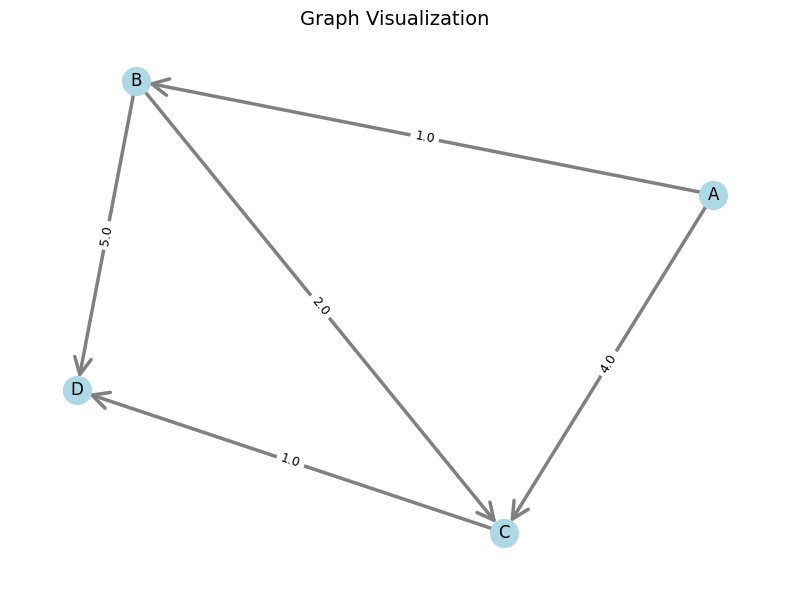

[2026-01-09 20:40:16,973] [INFO] All 2 tests passed for <__main__.DirectedGraphDijkstra object at 0x7f3abf7c2f30>.


In [4]:
graph_1 = AdjacencyListDirectedGraph(
    {
        GraphNode("A"): {GraphNode("B"): 1.0, GraphNode("C"): 4.0},
        GraphNode("B"): {GraphNode("C"): 2.0, GraphNode("D"): 5.0},
        GraphNode("C"): {GraphNode("D"): 1.0},
        GraphNode("D"): {},
    }
)

if __name__ == "__main__":
    graph_1.visualise()

    Validor(DirectedGraphDijkstra()).add_cases(
        [
            TestCase(
                input_data={"graph": graph_1, "start": GraphNode("A")},
                expected_output={
                    GraphNode("A"): 0,
                    GraphNode("B"): 1,
                    GraphNode("C"): 3,
                    GraphNode("D"): 4,
                },
            ),
            TestCase(
                input_data={"graph": graph_1, "start": GraphNode("B")},
                expected_output={
                    GraphNode("A"): math.inf,
                    GraphNode("B"): 0,
                    GraphNode("C"): 2,
                    GraphNode("D"): 3,
                },
            ),
        ],
    ).run(comparison=comparison)

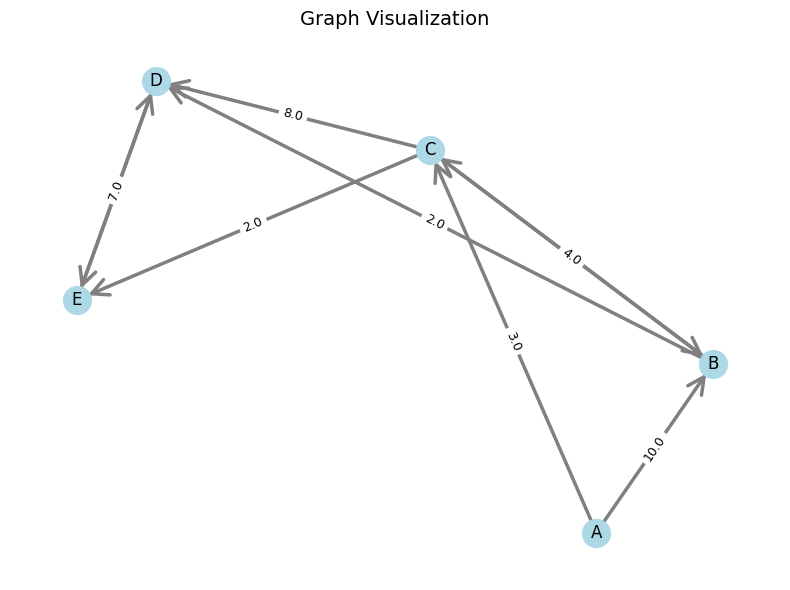

[2026-01-09 20:40:17,124] [INFO] All 2 tests passed for <__main__.DirectedGraphDijkstra object at 0x7f3abf2c72f0>.


In [5]:
graph_2 = AdjacencyListDirectedGraph(
    {
        GraphNode("A"): {GraphNode("B"): 10.0, GraphNode("C"): 3.0},
        GraphNode("B"): {GraphNode("C"): 1.0, GraphNode("D"): 2.0},
        GraphNode("C"): {GraphNode("B"): 4.0, GraphNode("D"): 8.0, GraphNode("E"): 2.0},
        GraphNode("D"): {GraphNode("E"): 7.0},
        GraphNode("E"): {GraphNode("D"): 9.0},
    }
)

if __name__ == "__main__":
    graph_2.visualise()

    Validor(DirectedGraphDijkstra()).add_cases(
        [
            TestCase(
                input_data={"graph": graph_2, "start": GraphNode("A")},
                expected_output={
                    GraphNode("A"): 0,
                    GraphNode("B"): 7,
                    GraphNode("C"): 3,
                    GraphNode("D"): 9,
                    GraphNode("E"): 5,
                },
            ),
            TestCase(
                input_data={"graph": graph_2, "start": GraphNode("C")},
                expected_output={
                    GraphNode("A"): math.inf,
                    GraphNode("B"): 4,
                    GraphNode("C"): 0,
                    GraphNode("D"): 8,
                    GraphNode("E"): 2,
                },
            ),
        ],
    ).run(comparison=comparison)